<a href="https://colab.research.google.com/github/hhduke2014/marked-beetle-analysis/blob/main/efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [49]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
filenames = os.listdir("/content/drive/MyDrive/MarkedBeetleImageAnalysis")
filenames[:4]

['PaperedControl20v_light.tif',
 'PaperedControl20d.tif',
 'PaperedControl20d_light.tif',
 'PaperedControl21v.tif']

In [66]:
train_images=[]
for filename in filenames:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}")

Number of Train images: 976


In [67]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [75]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('Marked')
    if filename.startswith('NoPapered'):
        categories.append('NotMarked')
len(categories)

976

In [76]:

train_df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
train_df

,filename,category
0,PaperedControl20v_light.tif,Marked
1,PaperedControl20d.tif,Marked
2,PaperedControl20d_light.tif,Marked
3,PaperedControl21v.tif,Marked
4,PaperedControl21v_light.tif,Marked
...,...,...
971,PaperedControl18v.tif,Marked
972,PaperedControl18d.tif,Marked
973,PaperedControl19v.tif,Marked
974,PaperedControl19d.tif,Marked


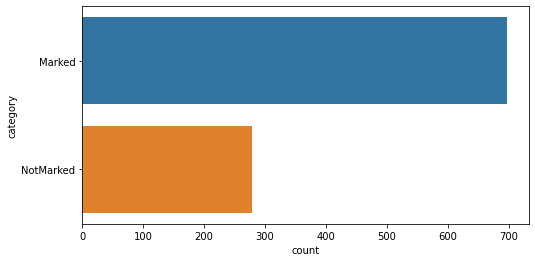

In [79]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=train_df);

In [80]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/MarkedBeetleImageAnalysis", filenames[0]))
image.shape

(1944, 2592, 3)

In [4]:
IMG_SIZE = 456
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 15

In [10]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB3

def create_model():
    
    model = Sequential()
    # initialize the model with input shape
    model.add(EfficientNetB3(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                             weights = 'imagenet',
                             drop_connect_rate=0.6))
    #for layer in model.layers[:-40]:  # Training just part of the architecture do not optimize the performance
    #    layer.trainable = False
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(n_CLASS, activation = 'softmax'))
    
    return model

leaf_model = create_model()
leaf_model.build((None,IMG_SIZE, IMG_SIZE, 3))
leaf_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_6 (ModuleWrap (None, 15, 15, 1536)      10783535  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1536)              0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1536)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               393472    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 1285      
Total params: 11,178,292
Trainable params: 11,090,989
Non-trainable params: 87,303
_____________________________________